In [16]:
import scipy.optimize as opt
import scipy.special as spec
import numpy as np
from math import *
import matplotlib.pyplot as plt
from DataSet import generateDataSet
from igraph import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from igraph import *
from DataSet import generateDataSet
import copy

In [17]:
## Compute the lambdas
def strength(i,j,p,vec):
    summ = 0
    for l in range(p):
        summ += vec[i,l]*vec[j,l]
    return summ

# n : Population / p : Number of communities / k : Number of ranks / a,b : Gamma parameters / w = Community parameter
#/ rho : Data rho[i,j] jth selection of the ith person
def posterior(n,p,k,w,rho):
    wPrior = w[:(p+1)]
    wLH = w[(p+1):]
    vec = wLH.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            if vec[i,u] == 0:
                summa += (wPrior[0]-1)*log(0.0000000001) - wPrior[1 + u]*vec[i,u] + wPrior[0]*log(wPrior[1 + u]) - spec.gamma(wPrior[0])
            else:
                summa += (wPrior[0]-1)*log(abs(vec[i,u])) - wPrior[1 + u]*vec[i,u] + wPrior[0]*log(wPrior[1 + u]) - spec.gamma(wPrior[0])
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

def posteriorNoDegree(n,p,k,a,b,w,rho):
    vec = w.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            if vec[i,u] == 0:
                summa += (a-1)*log(0.0000000001) - b*vec[i,u]
            else:
                summa += (a-1)*log(abs(vec[i,u])) - b*vec[i,u]
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

In [18]:
def drawGamma(a,b,n):
    return np.random.gamma(a,1/b,n)

def computeStrength(n,p,w):
    w1 = w.reshape((n,p))
    return (np.array([strength(i,j,p,w1) if i != j else 0 for i in range(n) for j in range(n)])).reshape((n,n))

def computeRho(strengthOrigin,n,K):
    strengths = np.array([[strengthOrigin[i,j] for j in range(n)] for i in range(n)])
    rho = np.zeros((n,K), dtype = int)
    for i in range(n):
        strength_i = strengths[i]
        strength_i_normalized = (1/(sum(strength_i)))*strength_i
        strength_i_cumulated = [(sum(strength_i_normalized[:(j+1)])) for j in range(n)]
        for j in range(K):
            r = np.random.rand()
            k = 0
            val = strength_i_cumulated[0]
            while r > val:
                k += 1
                val = strength_i_cumulated[k]
            rho[i,j] = k
            strengths[i,k] = 0
            strength_i = strengths[i]
            strength_i_normalized = (1/(sum(strength_i)))*strength_i
            strength_i_cumulated = [(sum(strength_i_normalized[:(l+1)])) for l in range(n)]
    return rho

def normalizeStrength(n,strengths):
    for i in range(n):
        strengths[i] = (1/sum(strengths[i]))*strengths[i]
    return strengths

def computeRealRho(strengths,n,K):
    rho = np.zeros((n,K), dtype = int)
    for i in range(n):
        listRank = [j for j in range(n)]
        strength_i = strengths[i]
        listRank = sorted(listRank, key=lambda b: strength_i[b])
        listRank.reverse()
        rho[i] = listRank[:K]
    return rho

def computeRemainingRho(strengthOrigin,n,rhoTest):
    t = len(rhoTest[0])
    strengths = np.array([[strengthOrigin[i,j] for j in range(n)] for i in range(n)])
    rho = np.zeros((n,n-1-t), dtype = int)
    for i in range(n):
        listRank = [u for u in range(n)]
        listRank.remove(i)
        strength_i = strengths[i]
        for taken in rhoTest[i]:
            listRank.remove(taken)
            np.delete(strength_i,taken)
        listRank = sorted(listRank, key = lambda b: strength_i[b])
        listRank.reverse()
        rho[i] = listRank
    return np.concatenate((rhoTest,rho),axis=1)


In [92]:
strengths = np.array([[0,10,19,20],[10,0,5,10], [19,5,0,3],[20,10,3,0]])
rhoTest = np.array([[1],[0],[1],[0]])
computeRemainingRho(strengths,4,rhoTest)

array([[1, 3, 2],
       [0, 3, 2],
       [1, 0, 3],
       [0, 1, 2]])

In [19]:
def mean(l):
    n = len(l)
    return (sum(l))/n

def AE(w1,w2,n):
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip(w1,w2))))/n

def rankingGap(w1,w2,n):
    rk1 = [i for i in range(n)]
    rk2 = [i for i in range(n)]
    rk1 = sorted(rk1, key=lambda i: w1[i])
    rk2 = sorted(rk2, key=lambda i: w2[i])
    rk2 = [rk2.index(i) for i in rk1]
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip([i for i in range(n)],rk2))))/n

In [20]:
def globalOpt(n,p,k,rho, w0 = 1):
    if type(w0) == int:
        w0 = 10*np.random.rand(n*p + p + 1)
    functionToOpt = lambda w : (-1)*posterior(n,p,k,w,rho)
    result = opt.fmin_l_bfgs_b(functionToOpt, w0,approx_grad=True, bounds = [(0.0000001, +inf) for i in range(n*p + p + 1)])
    return result

In [21]:
def optimizeCoor(n,p,k,rho,eps):
    w = 10*np.random.rand(n*p + p + 1)
    val = posterior(n,p,k,w,rho)
    flag2 = True
    flag = True
    while flag:
        for i in range(n*p + p + 1):
            w1 = np.delete(w,i)
            funcToOpt = lambda x : (-1)*posterior(n,p,k,np.insert(w1,i,x),rho)
            res, val1, msg = opt.fmin_l_bfgs_b(funcToOpt, np.array([w[i]]),approx_grad=True, bounds = [(0.000000000001,+inf)])
            if flag2:
                if val1 < 0:
                    flag2 = False
                    print("Original:",w)
                    print("Final:", np.insert(w1,i,res))
                    print("Difference:", w - np.insert(w1,i,res))
                    print("NUmber:", i)
            w = np.insert(w1,i,res)
        if abs(val1-val) < eps:
            print(val1)
            return w, val1
        else:
            val = val1
        print(val)

In [22]:
def optimizeCoorNoDegree(n,p,k,a,b,rho,eps):
    w = 10*np.random.rand(n*p)
    val = posteriorNoDegree(n,p,k,a,b,w,rho)
    flag = True
    while flag:
        for i in range(n*p):
            w1 = np.delete(w,i)
            funcToOpt = lambda x : (-1)*posteriorNoDegree(n,p,k,a,b,np.insert(w1,i,x),rho)
            res, val1, msg = opt.fmin_l_bfgs_b(funcToOpt, np.array([w[i]]),approx_grad=True, bounds = [(0,+inf)])
            w = np.insert(w1,i,res)
        if abs(val1-val) < eps:
            return w, val1
        else:
            val = val1

In [23]:
def globalOptNoDegree(n,p,k,a,b,rho):
    w0 = 10*np.random.rand(n*p)
    functionToOpt = lambda w : (-1)*posteriorNoDegree(n,p,k,a,b,w,rho)
    result = opt.fmin_l_bfgs_b(functionToOpt, w0,approx_grad=True, bounds = [(0.000000001, +inf) for i in range(n*p)])
    return result

## Simulation

In [ ]:
n = 25
p = 3
k = 4
a = 2
b = 2
listElementGap = []
listElementAE = []
for i in range(10):
    gammaParameters = drawGamma(2,1,p+1)
    drawW = np.array([])
    for j in range(p):
        drawW = np.append(drawW, [drawGamma(gammaParameters[0], gammaParameters[j + 1], n)])
    drawW = drawW.reshape((p,n))
    drawW = drawW.T
    drawW = drawW.reshape((n*p,))
    w = drawW
    strengths = computeStrength(n,p,w)
    rho = computeRho(strengths,n,k)
    resultGlobal = globalOpt(n,p,k,rho)
    for j in range(15):
        resultGlobal = globalOpt(n,p,k,rho, w0 = resultGlobal[0])
    strengths = strengths.reshape((n*n,))
    strengthGlb = normalizeStrength(n,computeStrength(n,p,resultGlobal[0]))
    strengthGlb = strengthGlb.reshape((n*n,))
    listnGap = []
    listnAE = []
    for numInd in range(n):
        listnGap.append(rankingGap(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))
        listnAE.append(AE(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))
    listElementGap.append(mean(listnGap))
    listElementAE.append(mean(listnAE))
print(listElementGap)
print(listElementAE)

print("Mean Gap", mean(listElementGap))
print("Mean AE", mean(listElementAE))

plt.plot([i for i in range(n)], listElementGap, '-b' ,label = 'Mean Ranking Gap over each individuals')
plt.legend()
plt.savefig("SimulationGap")
plt.show()

In [24]:
n = 25
p = 3
k = 4
a = 2
b = 2
gammaParameters = np.random.rand(4)*2 + 1
print(gammaParameters)
drawW = np.array([])
for j in range(p):
    drawW = np.append(drawW, [drawGamma(gammaParameters[0], gammaParameters[j + 1], n)])
drawW = drawW.reshape((p,n))
drawW = drawW.T
drawW = drawW.reshape((n*p,))
w = drawW
print(w)
strengths = computeStrength(n,p,w)
print(strengths)
rho = computeRho(strengths,n,k)
realRho = computeRealRho(strengths,n,k)

[1.7131669  1.07252672 1.48421408 2.58151689]
[1.55923429 0.71411517 2.06202102 2.21743693 0.41117235 0.28922198
 1.78913549 0.89407424 1.68453786 0.36499058 4.86818435 0.69440625
 2.36338083 0.89070043 0.32607868 0.84825651 0.57510915 2.24852759
 0.93752179 0.14043609 0.47490754 0.9773356  1.66124551 0.15788017
 1.0610239  0.56915557 1.53004883 3.62202709 0.85868198 1.37768736
 0.68556443 1.09955153 0.0741078  1.8550877  1.59146332 0.53223975
 2.42848181 0.32766641 0.52196749 0.82408774 1.15934656 0.05148393
 1.0143786  2.6641022  1.51796796 0.85212855 3.32370082 0.39855168
 1.93569485 1.78204309 0.2126274  2.65707625 1.05888715 0.22533727
 1.13662531 0.15616229 0.78211845 1.48133493 0.60651082 0.51242096
 0.77282624 0.33004066 0.19392893 0.32171028 1.23006156 1.47531323
 4.220795   0.32421302 0.82581566 2.17724821 0.53264703 0.89751521
 1.65876491 1.53419067 1.53021205]
[[ 0.          4.3475099   6.90170584  5.47743041  4.99350819  6.36983596
   2.54137299  3.03576803  5.21582033  9.

In [47]:
l1 = np.array([1,2])
l2 = np.array([3,4])
np.concatenate((l1,l2))

array([1, 2, 3, 4])

[1.7131669  1.48421408 2.58151689]


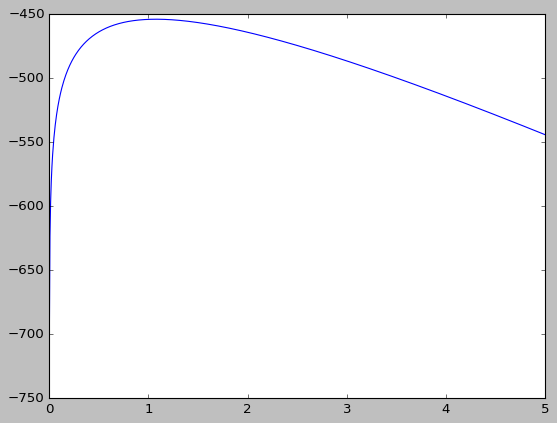

In [48]:
lin1 = np.linspace(0.001,5,750)
wTest = np.array([w[i] for i in range(len(w))])
gammaTest = np.array([gammaParameters[i] for i in range(len(gammaParameters))] )
gammaTest = np.delete(gammaTest,1)
print(gammaTest)
yVals = [posterior(n,p,k,np.concatenate(( np.insert(gammaTest,1,val) ,wTest)),rho) for val in lin1]
plt.plot(lin1,yVals)
plt.savefig("CoordinateWiseFunction.png")

In [26]:
resultGlobal = globalOpt(n,p,k,rho)
for i in range(50):
    resultGlobal = globalOpt(n,p,k,rho, w0 = resultGlobal[0])
    
print(resultGlobal)

/home/pierre/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


(array([2.63418723e-01, 8.14934090e+00, 8.25638486e+00, 8.18618345e+00,
       1.00000000e-07, 2.05467942e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 4.17475733e-07, 1.00000000e-07, 3.77715344e-07,
       1.00000000e-07, 3.91296826e-07, 1.00000000e-07, 1.00000000e-07,
       4.20054635e-07, 1.00000000e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07, 1.50804753e-07,
       1.00000000e-07, 5.34304387e-07, 1.00000000e-07, 7.56805870e-07,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 1.00000000e-07, 1.34844171e-07, 1.00000000e-07,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 2.81506517e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07, 1.00000000e-07,
     

In [28]:
eps = 0.00001
result = optimizeCoor(n,p,k,rho,eps)
print(result)


552.3787633738203
502.81131421701286
468.53193335496536
423.12423431277807
349.09634912341147
Original: [5.99259758e-01 9.98582192e+01 1.48134970e+00 7.73632676e-01
 1.00000000e-12 1.00000000e-12 5.31589903e-01 1.00000000e-12
 6.59398261e-01 1.00000000e-12 1.00000000e-12 1.00000000e-12
 1.22554769e+00 1.00000000e-12 1.00000000e-12 9.77737953e-01
 1.00000000e-12 1.00000000e-12 9.27330990e-01 1.00000000e-12
 1.00000000e-12 4.78867841e-01 1.00000000e-12 1.00000000e-12
 4.69178875e-01 1.00000000e-12 3.53062617e-01 1.00000000e-12
 1.00000000e-12 1.00000000e-12 8.72016422e-01 1.00000000e-12
 1.03497778e-01 1.05929005e+00 1.00000000e-12 1.00000000e-12
 2.53134645e-01 1.00000000e-12 1.00000000e-12 2.49384585e-01
 1.00000000e-12 2.53926286e-01 1.38008993e-01 1.00000000e-12
 2.25708628e-01 1.41485935e-01 1.00000000e-12 1.00000000e-12
 2.32854811e-01 1.00000000e-12 1.77094001e-02 1.25496197e+00
 6.13346394e-03 3.00987278e-02 9.74226237e-01 5.83355439e-03
 1.28554838e+00 1.08385766e+00 6.79546665e

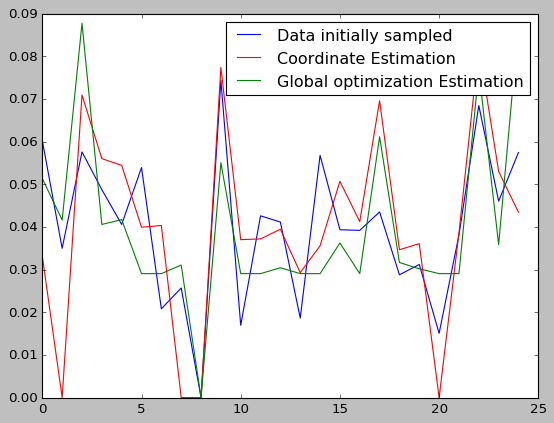

Ranking Gap Coordinate 4.16
Ranking Gap Global 4.64
AE Coordinate 0.012731887571593064
AE Global 0.011739778754466827


In [34]:
numInd = 8
strengthEstimated = normalizeStrength(n,computeStrength(n,p,result[0][(p+1):]))
strengths = normalizeStrength(n,computeStrength(n,p,w))
strengthEstimated = strengthEstimated.reshape((n*n,))
strengths = strengths.reshape((n*n,))
strengthGlb = normalizeStrength(n,computeStrength(n,p,resultGlobal[0][(p+1):]))
strengthGlb = strengthGlb.reshape((n*n,))
plt.plot([i for i in range(n)], strengths[numInd*n:(numInd+1)*n], '-b' ,label = 'Data initially sampled')
plt.plot([i for i in range(n)], strengthEstimated[numInd*n:(numInd+1)*n], '-r' , label = 'Coordinate Estimation')
plt.plot([i for i in range(n)], strengthGlb[numInd*n:(numInd+1)*n], '-g' ,label = 'Global optimization Estimation')
plt.legend()
#plt.title("Estimation of the link between the first individual with the others")
plt.savefig("LambdaEstimation")
plt.show()
print("Ranking Gap Coordinate", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("Ranking Gap Global", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

print("AE Coordinate", AE(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("AE Global", AE(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

[1.48343104 4.33265751 2.88584219 3.55769572]
[ 8.77567267  1.1114724   4.82296524  0.22276279  2.36206266  2.5063563
  6.81776768  6.98473224  4.5986493   6.32517517  1.45345064  6.95321117
 12.56043477  4.94691827  6.66093341 20.80253678  7.29593566 10.13380453
  5.42386633  2.04613773  2.04692601 18.29237221  1.12560867  3.62423342
  5.31509819  3.03912992  5.4453416   2.96577328  8.04758834  1.29453203]
[[0.         0.01771357 0.09540246 0.09634324 0.15712149 0.25456162
  0.06349103 0.19049948 0.0810678  0.04379932]
 [0.07616733 0.         0.13499909 0.10176179 0.14246865 0.21598783
  0.05104987 0.07227819 0.10057922 0.10470803]
 [0.09258873 0.0304696  0.         0.08792485 0.15554881 0.24689737
  0.06258684 0.15392283 0.08509366 0.08496729]
 [0.10625862 0.02610147 0.09992082 0.         0.15583017 0.24923846
  0.06037798 0.16706644 0.08895935 0.04624668]
 [0.10692219 0.02254701 0.10906877 0.09614815 0.         0.26387522
  0.06644767 0.1876429  0.08538246 0.06196563]
 [0.11982146 0

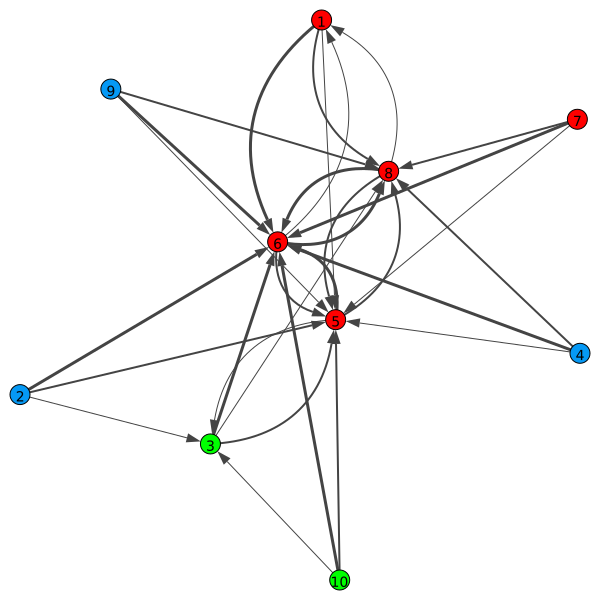

In [60]:
g = Graph(directed=True)
g.add_vertices(n)
print(gammaParameters)
print(w)
strengths = normalizeStrength(n,computeStrength(n,p,w))
print(strengths)
strengths = strengths.reshape((n*n,))
comm = w.reshape((n,p))
for i in range(n):
    listToSort = [i for i in range(n)]
    listStrengthOrigin_i = strengths[i*n : (i+1)*n]
    listSorted = sorted(listToSort, key=lambda x: listStrengthOrigin_i[x])
    listSorted.reverse()
    print(listSorted)
    for j in range(k):
        g.add_edge(i,listSorted[j], width=k-j)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax(comm[i])] for i in range(n)]
out = plot(g)
out.save("OriginalPlot.png")
out

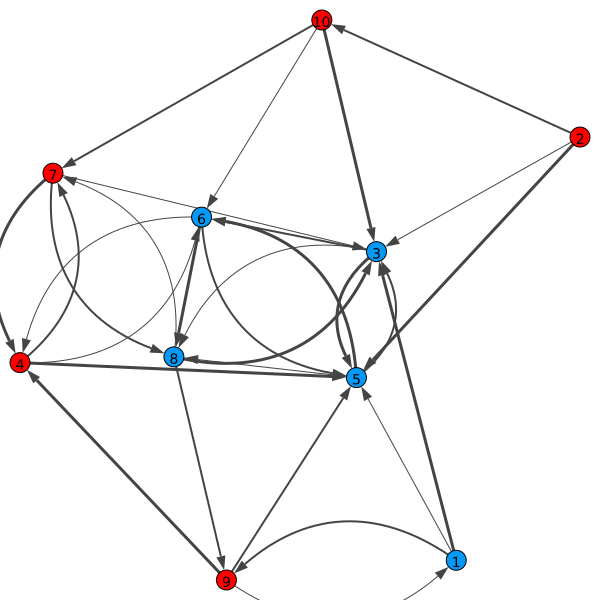

In [61]:
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(k):
        g.add_edge(i,rho[i,j], width=k-j)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax((resultGlobal[0][(p+1):].reshape((n,p)))[i])] for i in range(n)]
out = plot(g)
out.save("OptimizationPlot.png")
out

### Evaluation

#### Fixed parameter prior

In [109]:
n = 15
k = 3
p = 3
a = 2
b = 2
eps = 0.000001




rho = computeRho(strengths,n,n-1)
rhoTest = rho[:,:k]
print(rhoTest)
#globalOpt(n,p,k,rho)
#optimizeCoor(n,p,k,rho,eps)

wCoor = optimizeCoorNoDegree(n,p,k,a,b,rho,eps)[0]
wGlb = globalOptNoDegree(n,p,k,a,b,rho)[0]
strCoor = computeStrength(n,p,wCoor)
strGlb = computeStrength(n,p,wGlb)
rhoCoor = computeRemainingRho(strCoor,n,rhoTest)[:,k:]
rhoGlb = computeRemainingRho(strGlb,n,rhoTest)[:,k:]
trueRho = rho[:,k:]
print(rhoCoor, trueRho)
print(mean([rankingGap(rhoGlb[i],rhoCoor[i],n-1-k) for i in range(n)]))
print(mean([rankingGap(rhoGlb[i],trueRho[i],n-1-k) for i in range(n)]))


/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


[[ 4  5  1]
 [ 3  0  2]
 [ 6  7  9]
 [ 8  6  5]
 [ 2 14 13]
 [12  8  0]
 [14  1  8]
 [ 2  4  0]
 [ 2  1 13]
 [ 2  0  4]
 [11  1 12]
 [ 8  9  7]
 [ 3  6  8]
 [ 1  3 11]
 [ 7 13  4]]
[[ 2  8  7  3  6 13 14  9 11 12 10]
 [ 8  6 13  4 12  5  7 11 14  9 10]
 [ 4  0  1  8 14 13 11  3  5 12 10]
 [ 1  2  0 12 13  4 11  7 14  9 10]
 [ 7  0  1  9  8  6 11  3  5 12 10]
 [ 1  3  2  6 13  4 11  7 14  9 10]
 [ 2  3  0  4 13 12  5  7 11  9 10]
 [ 1  9 14  8 13  6 11  3  5 12 10]
 [ 3  6  0 12  5  4 11  7 14  9 10]
 [ 7  1  8 14 13  6 11  3  5 12 10]
 [ 8  2  3  0  6 13  4  5  7 14  9]
 [ 2  1  4  0  3  6 13 14 12  5 10]
 [ 1  2  0 13  5  4 11  7 14  9 10]
 [ 8  2  0  4  6  7 12  5 14  9 10]
 [ 2  1  0  8  9  6  3 11  5 12 10]] [[11  9 13  6  3  8  7 10 14 12  2]
 [10  4  6 11 12  8  9  7  5 13 14]
 [ 1  8  4 11 10  5 13  3  0 14 12]
 [13 14  0 12  9 10  1  4  2 11  7]
 [11  3 12 10  6  9  1  0  5  7  8]
 [ 9 14  2 11 10  6 13  3  4  1  7]
 [ 4  2 10  0  3  5 12  7  9 13 11]
 [12 11  8  3 10  5 14  6 